In [2]:
from glob import glob
import numpy as np
from fish.util.fileio import load_image, load_images
import matplotlib.pyplot as plt
plt.style.use('presentation')
%matplotlib notebook

from skimage.exposure import rescale_intensity
from fish.util.plot import ROI, RoiDrawing
from fish.image.vol import get_stack_freq

fnames = sorted(glob('/groups/ahrens/ahrenslab/davis/data/spim/raw/20170802/7dpf_cy252xcy293_f1_opto_1_20170802_220339/TM*'))
fs_im = get_stack_freq('/groups/ahrens/ahrenslab/davis/data/spim/raw/20170802/7dpf_cy252xcy293_f1_opto_1_20170802_220339/')[0] * 50

In [9]:
def minimal_axis(ax, scales, offsets=(0,0), **kwargs):
    ax.axis('off')
    origin = (ax.get_xlim()[0] + offsets[0], ax.get_ylim()[0] + offsets[1])
    
    ax.plot([origin[0], scales[0]], [origin[1], origin[1]], **kwargs)
    ax.plot([origin[0], origin[0]], [origin[1], scales[1]], **kwargs)

In [10]:
%%time
to_load = slice(100, 121)
ims = load_images(fnames[to_load], -1)

CPU times: user 3.16 s, sys: 4.18 s, total: 7.34 s
Wall time: 9.35 s


In [11]:
ims = ims.reshape(ims.shape[0] * ims.shape[1], *ims.shape[2:])

In [12]:
mean_ts = rescale_intensity(ims.mean((1,2)), out_range=(0,1)) 

<IPython.core.display.Javascript object>


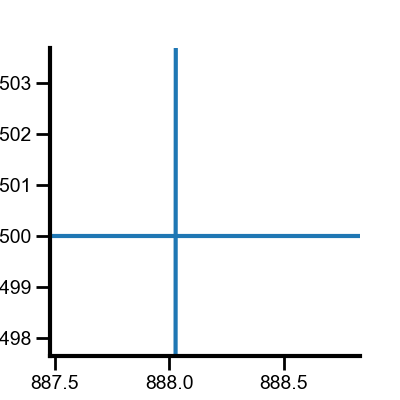

In [84]:
from skimage.exposure import rescale_intensity
plt.figure(1,(4,4))
plt.plot(mean_ts)
thr = .05
plt.axhline(thr)
plt.show()

In [7]:
from scipy.ndimage.filters import gaussian_filter
mean_im = ims[mean_ts < thr].mean(0)

<IPython.core.display.Javascript object>


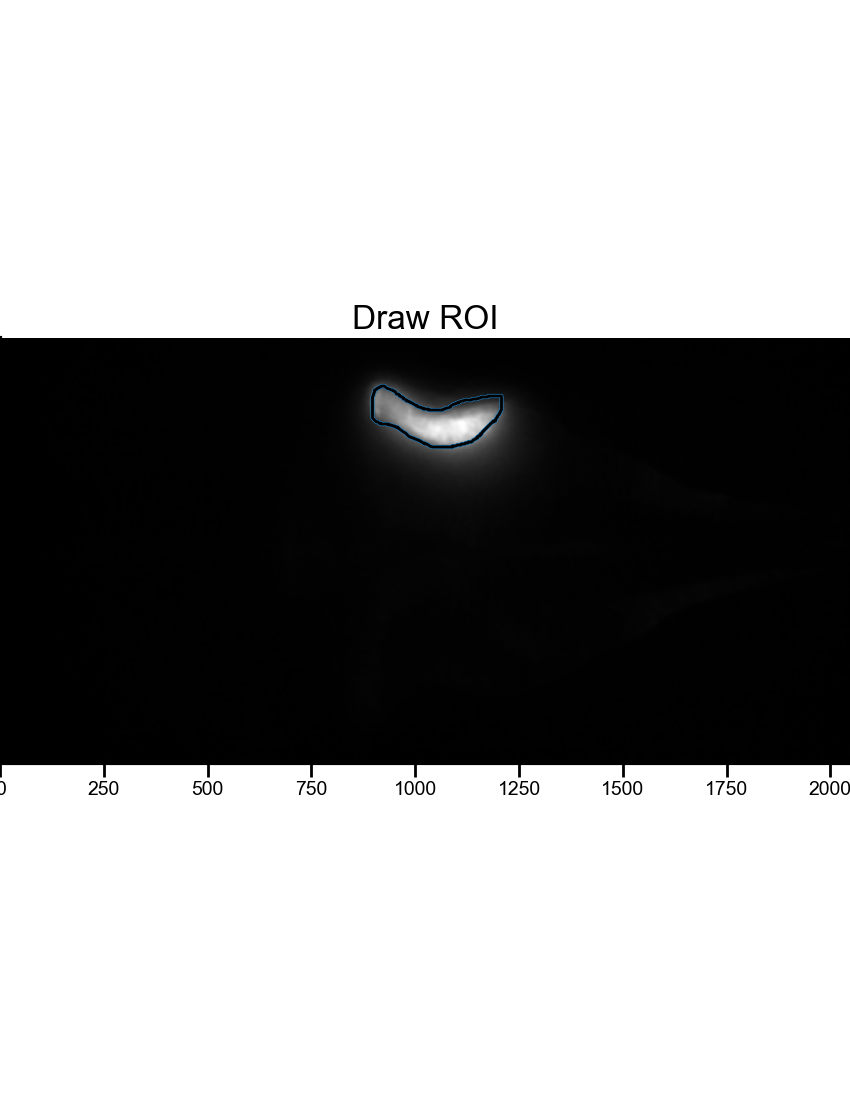

In [87]:
fig = plt.figure()
ax = plt.axes([0, 0, 1, 1])
ax.set_title('Draw ROI')
ax.imshow(gaussian_filter(ims[900], [3,3]), cmap='gray')
roi_draw = RoiDrawing(ax, mean_im)

In [88]:
roi = roi_draw.rois[0]
roi_mask = roi.get_mask()

In [89]:
# get the roi timeseries

In [92]:
%%time
from multiprocessing import Pool
from fish.image.vol import dff
def roi_mean(v):
    return v[roi_mask.astype('bool')].mean()
with Pool(8) as p:
    ts_mean = np.array(p.map(roi_mean, ims))

ts_mean = dff(ts_mean, window = int(fs_im * 100), percentile=20, baseline_offset=.1)

CPU times: user 3.66 s, sys: 4.05 s, total: 7.71 s
Wall time: 9.49 s


<IPython.core.display.Javascript object>


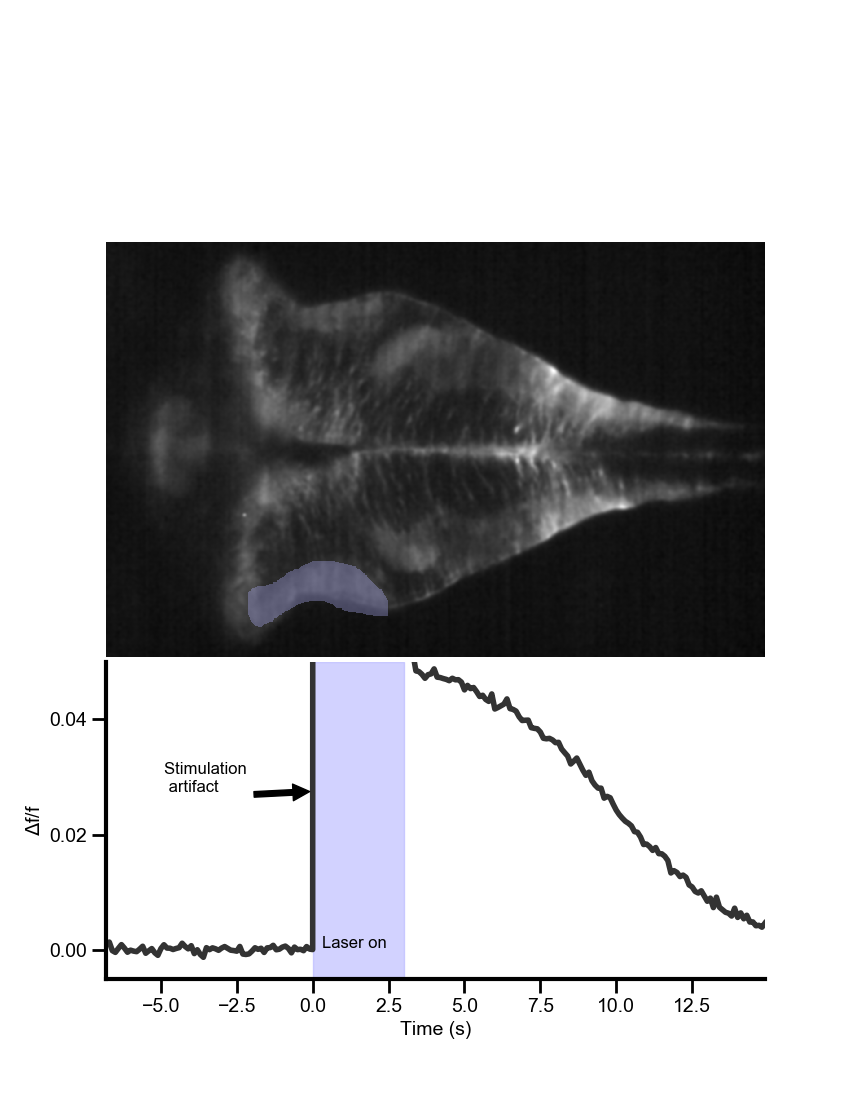

In [151]:
from skimage.color import gray2rgb
import matplotlib as mpl
label_size = 14
ref = gaussian_filter(mean_im, [3,3])
crop = (slice(50, -50), slice(580, None))

ref_rgb = gray2rgb(rescale_intensity(ref[crop], out_range=(0,1)))
mask_rgb = gray2rgb(roi_mask[crop].astype('uint8'))
mask_rgb = np.concatenate([mask_rgb, np.zeros((*mask_rgb.shape[:-1], 1), dtype='uint8')], 2)
mask_rgb[:,:,-1] = mask_rgb[:,:,0] / 3
mask_rgb[:,:,0] = 180
mask_rgb[:,:,1] = 180

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(8.5, 11), gridspec_kw = {'height_ratios' : (2,1)})

axs[0].imshow(ref_rgb, origin='lower')
axs[0].imshow(mask_rgb, origin='lower')
axs[0].axis('off')

plr_ts = slice(820, 1038)
laser_on = 888 / fs_im
laser_off = laser_on + 3
stim_window = np.array([laser_on, laser_off])
ylim = -0.005, .05
x_axis = (np.arange(len(ts_mean))[plr_ts] / fs_im) - laser_on
laser_on_inds = ~np.logical_and(x_axis > 0, x_axis < ( laser_off - laser_on))
# plot pre, post stim separately
x_pre = x_axis < 0
x_post = x_axis > (laser_off - laser_on)
axs[1].plot(x_axis, ts_mean[plr_ts], color=[.2,.2,.2], linewidth=4)
#axs[1].plot(x_axis[x_pre], ts_mean[plr_ts][x_pre], color=[.2,.2,.2], linewidth=5)
#axs[1].plot(x_axis[x_post], ts_mean[plr_ts][x_post], color=[.2,.2,.2], linewidth=5)
axs[1].set_xlim((x_axis[0], x_axis[-1]))
scale_x, scale_y = .5, .025
axs[1].axvspan(0, laser_off - laser_on, zorder=0, alpha = .6, color=(180/255,180/255,1))
axs[1].set_ylabel(r'$\Delta$f/f', fontsize=label_size)
axs[1].set_xlabel('Time (s)', fontsize=label_size)
plt.subplots_adjust(hspace=-.22,wspace=0)

axs[1].annotate('Stimulation \n artifact', 
                xy=(-.1, np.diff(ylim) / 2), 
                xytext=(-4.9, 1 * np.diff(ylim) / 2),
               arrowprops=dict(facecolor='black'))

axs[1].text(0.3, np.diff(ylim) / 120, 'Laser on')
axs[1].set_ylim(ylim)
axs[1].set_yticks(axs[1].get_yticks()[1::2])
plt.savefig('/groups/ahrens/ahrenslab/projects/ngm/presentation/resource/opto_stim_validation.pdf')